# Auto_MPG_Dataset
## Mileage per gallon performances of various cars
### Decision-Tree for Regression


In [1]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as MSE
#XGBoost
from xgboost import XGBRegressor
# #warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
#Loading Data
data = pd.read_csv('auto-mpg.csv')
data.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


### About the data
-  This dataset was taken from the StatLib library which is
maintained at Carnegie Mellon University. The dataset was
used in the 1983 American Statistical Association Exposition.
- Attribute Information:

    - mpg: continuous
    - cylinders: multi-valued discrete
    - displacement: continuous
    - horsepower: continuous
    - weight: continuous
    - acceleration: continuous
    - model year: multi-valued discrete
    - origin: multi-valued discrete
    - car name: string (unique for each instance)

## Data Exploration


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [5]:
del data['car name']

In [6]:
# checking if there are values other than digits in the column 'horsepower' 
hpIsDigit = pd.DataFrame(data.horsepower.str.isdigit())  
# if the string is made of digits store True else False

# print isDigit = False!
data[hpIsDigit['horsepower'] == False]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
32,25.0,4,98.0,?,2046,19.0,71,1
126,21.0,6,200.0,?,2875,17.0,74,1
330,40.9,4,85.0,?,1835,17.3,80,2
336,23.6,4,140.0,?,2905,14.3,80,1
354,34.5,4,100.0,?,2320,15.8,81,2
374,23.0,4,151.0,?,3035,20.5,82,1


In [7]:
#Relacing ? with np.nan
data = data.replace('?', np.nan)
data[hpIsDigit['horsepower'] == False]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,1
126,21.0,6,200.0,NaN,2875,17.0,74,1
330,40.9,4,85.0,NaN,1835,17.3,80,2
336,23.6,4,140.0,NaN,2905,14.3,80,1
354,34.5,4,100.0,NaN,2320,15.8,81,2
374,23.0,4,151.0,NaN,3035,20.5,82,1


In [8]:
# Imputing the missing values with median value
data.horsepower.fillna(data.horsepower.median(), inplace=True)

# converting the hp column from object data type to float
data['horsepower'] = data['horsepower'].astype('float64') 

In [9]:
data['origin']=data['origin'].replace([1,2,3],['USA','Europe','Japan'])

In [10]:
data.origin.value_counts()

USA       249
Japan      79
Europe     70
Name: origin, dtype: int64

In [11]:
data.origin.value_counts(normalize=True)

USA       0.625628
Japan     0.198492
Europe    0.175879
Name: origin, dtype: float64

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,104.304020,38.222625,46.0,76.000,93.5,125.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


In [13]:
data.cov()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
mpg,61.089611,-10.308911,-655.402318,-231.067162,-5505.211745,9.058930,16.741163
cylinders,-10.308911,2.893415,168.623214,54.697663,1290.695575,-2.370842,-2.193499
displacement,-655.402318,168.623214,10872.199152,3570.094379,82368.423240,-156.332976,-142.717137
horsepower,-231.067162,54.697663,3570.094379,1460.969052,27915.978893,-72.370753,-58.474096
weight,-5505.211745,1290.695575,82368.423240,27915.978893,717140.990526,-974.899011,-959.946344
acceleration,9.058930,-2.370842,-156.332976,-72.370753,-974.899011,7.604848,2.938105
model year,16.741163,-2.193499,-142.717137,-58.474096,-959.946344,2.938105,13.672443


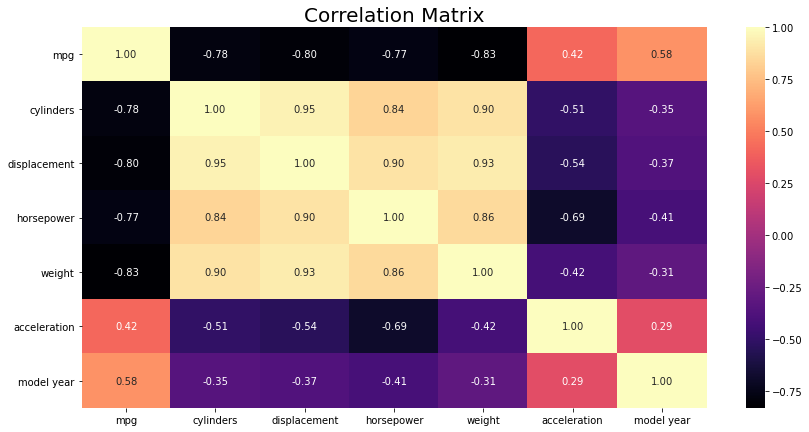

In [14]:
f, ax = plt.subplots(figsize=[14,7])
sns.heatmap(data.corr(),annot=True,fmt='.2f',ax=ax,cmap='magma')
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

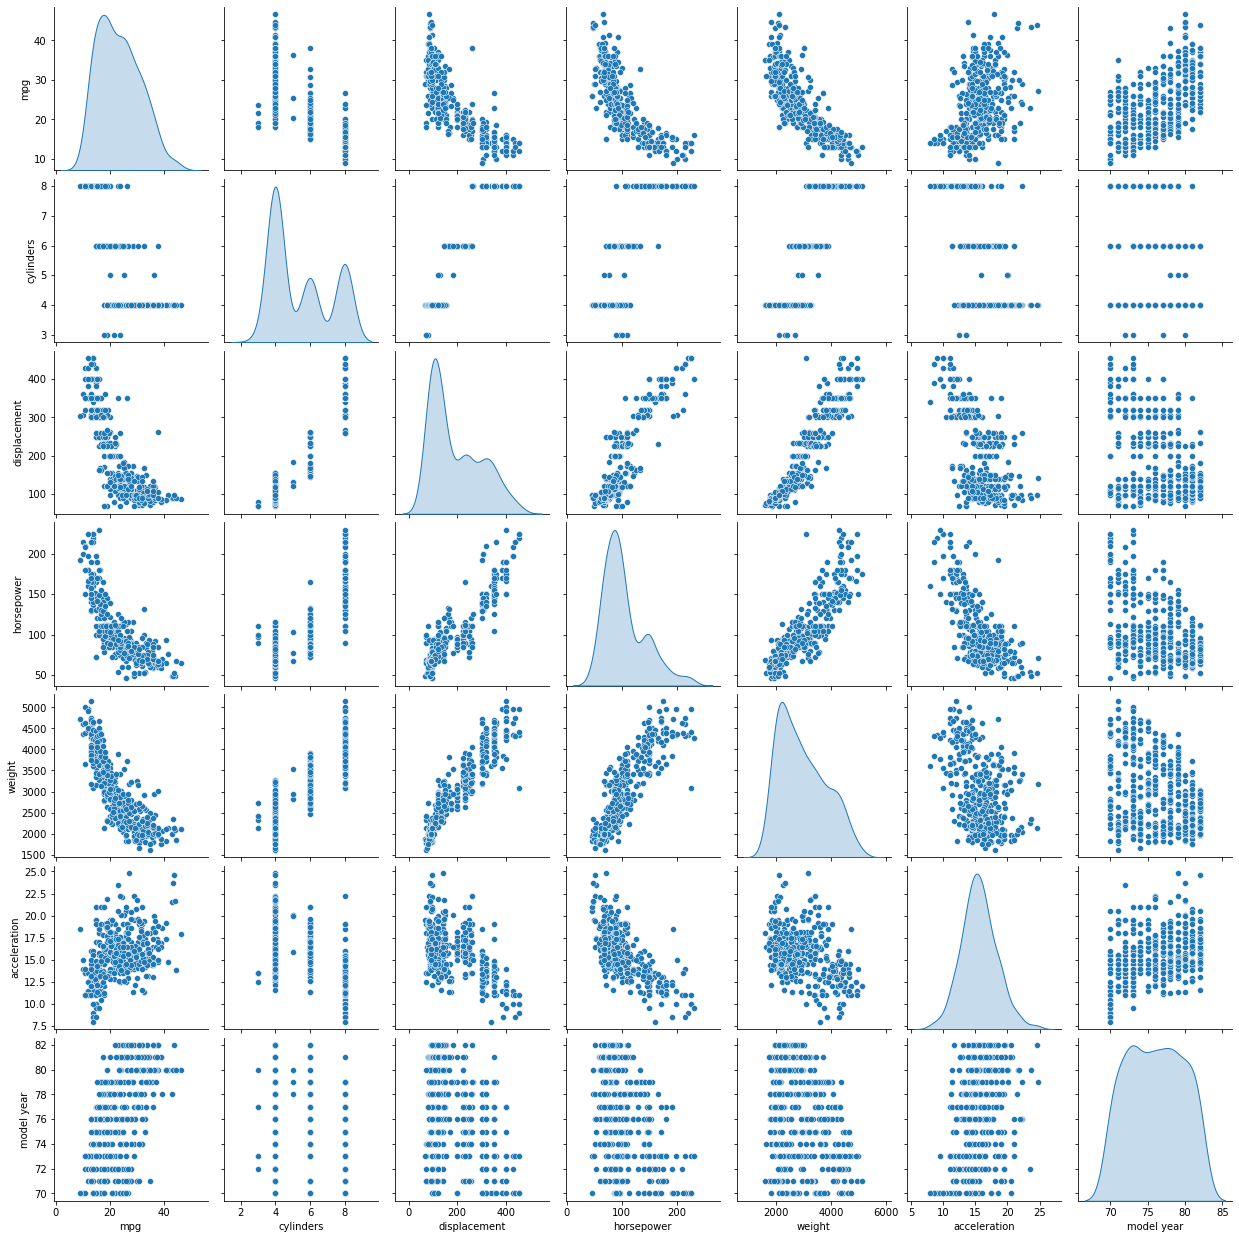

In [15]:
sns.pairplot(data,diag_kind='kde')

Text(0.5, 1.0, 'Consumption Gallon by Years')

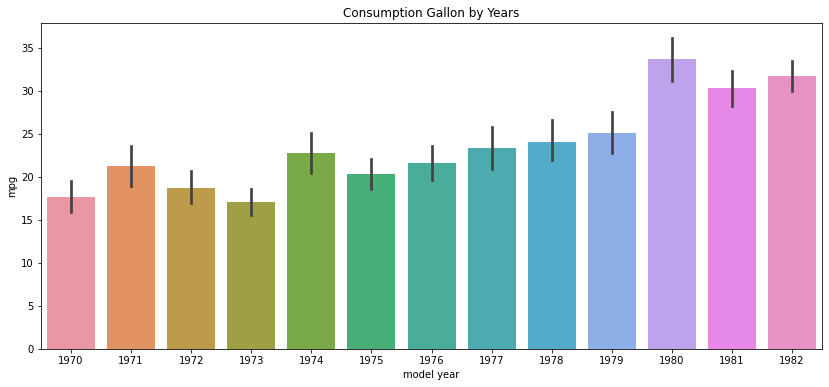

In [16]:
plt.figure(figsize=[14, 6])
sns.barplot(x=data['model year']+1900, y=data['mpg'])
plt.title('Consumption Gallon by Years')

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


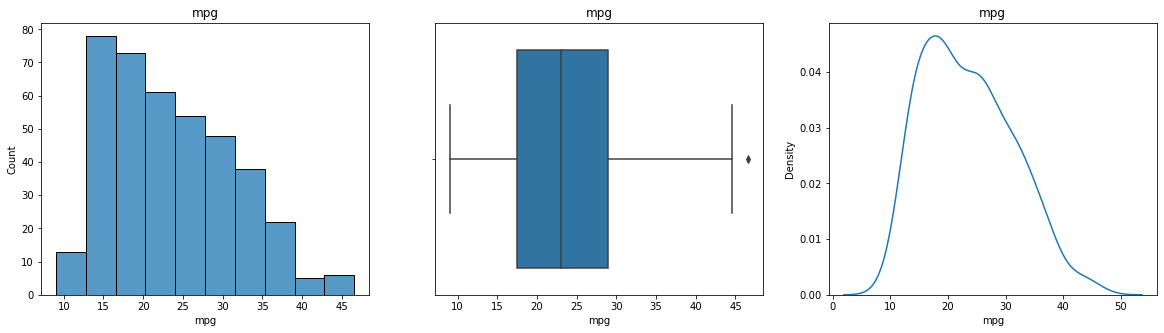

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


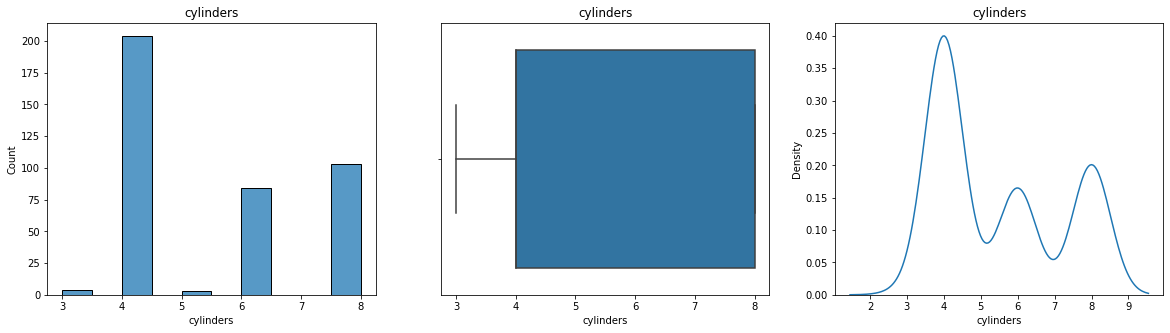

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


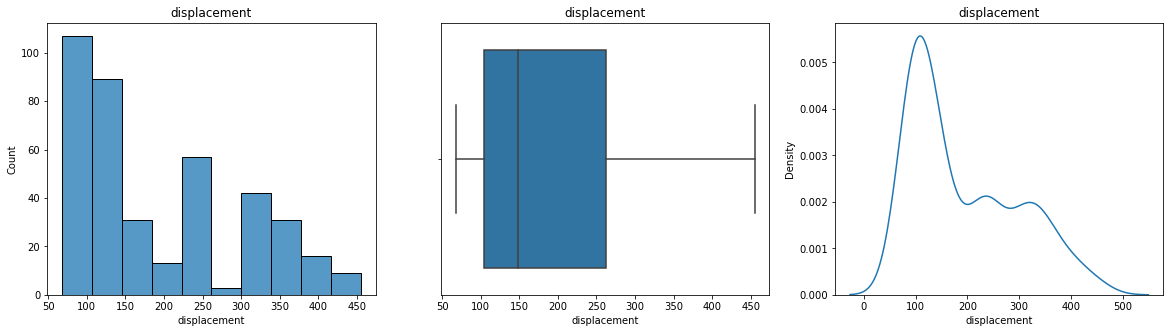

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


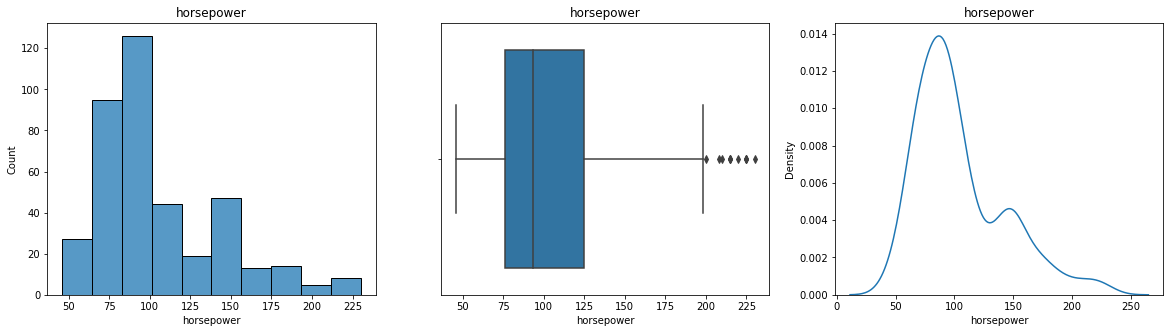

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


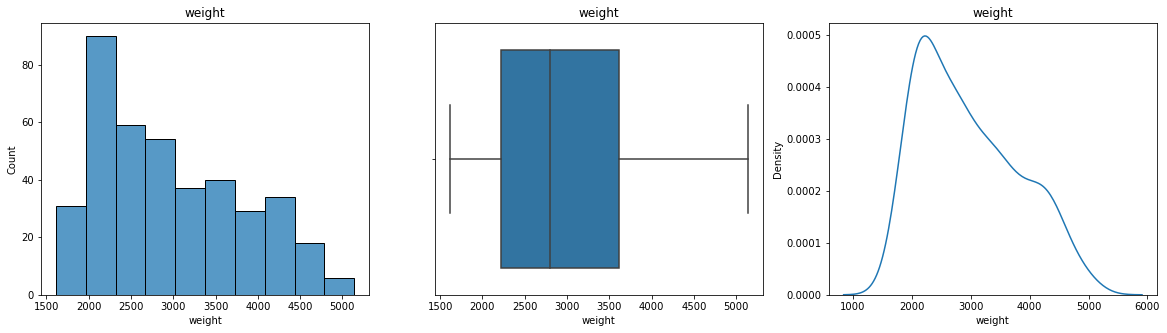

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


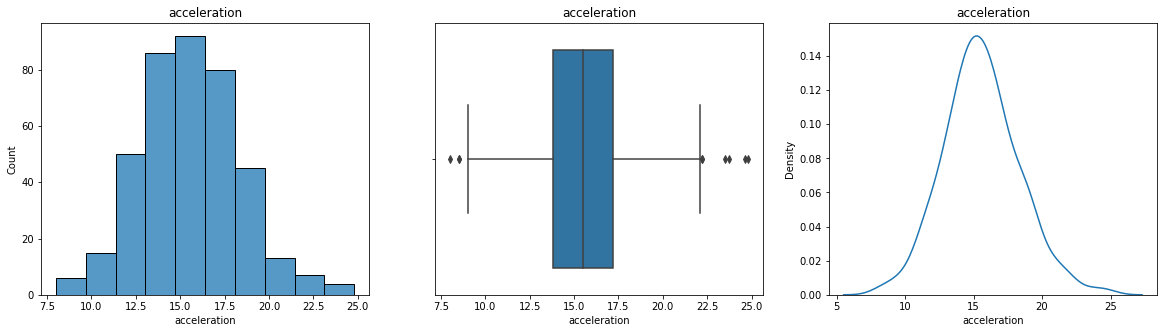

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


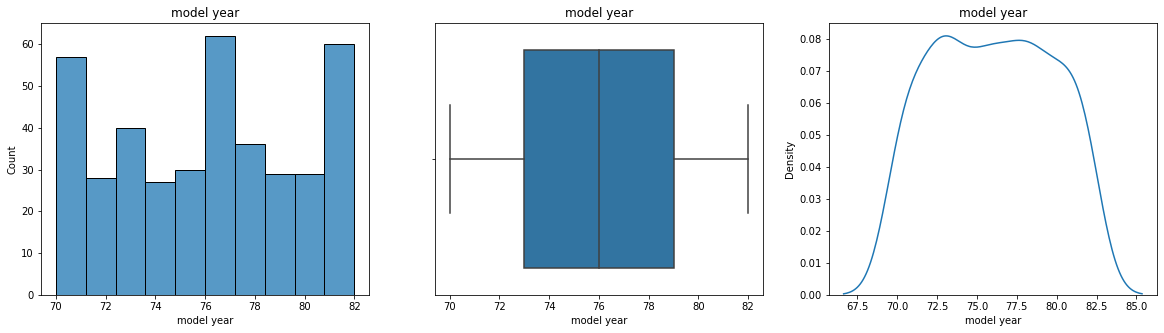

In [17]:
for i in data._get_numeric_data().columns:
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
    sns.histplot(data[i],bins=10,ax=ax[0])
    ax[0].set_title(i)
    
    sns.boxplot(data[i],ax=ax[1])
    ax[1].set_title(i)
    
    sns.kdeplot(data[i],ax=ax[2])
    ax[2].set_title(i)
    
    plt.show()

In [18]:
#Outliers
def outlier(df,column):
    Q1=df[column].quantile(0.00)
    Q3=df[column].quantile(0.95)
    IQR_hp=Q3-Q1
    top_limit=Q3+ 1.5*IQR_hp
    bottom_limit=Q1- 1.5*IQR_hp
    return df[(df[column]>=bottom_limit) & (df[column]<=top_limit) ]

In [19]:
data = outlier(data,'horsepower')

In [20]:
data = outlier(data,'acceleration')

## Feature Engineering

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mpg', ylabel='Density'>

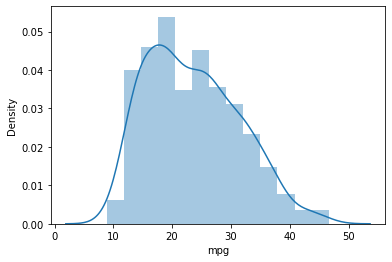

In [22]:
#skewess
from scipy import stats
from scipy.stats import norm, skew
sns.distplot(data['mpg'])

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mpg', ylabel='Density'>

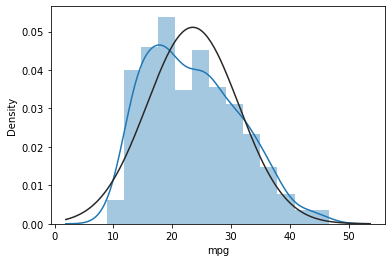

In [23]:
from scipy import stats
from scipy.stats import norm, skew
sns.distplot(data['mpg'],fit=norm)

In [24]:
(mu, sigma)=norm.fit(data['mpg'])
print(mu, sigma)

23.514572864321607 7.806159061274433


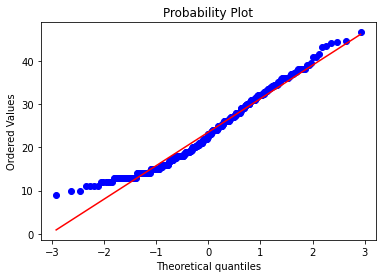

In [25]:
#qq plot
fig=plt.figure()
stats.probplot(data['mpg'], plot=plt)
plt.show()

In [26]:
data['mpg'] = np.log1p(data['mpg'])

C:\Users\baoanhcr7\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mpg', ylabel='Density'>

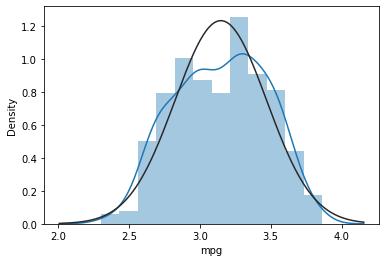

In [27]:
sns.distplot(data['mpg'],fit=norm)

In [28]:
(mu, sigma)=norm.fit(data['mpg'])
print(mu, sigma)

3.1478302770344047 0.32375928015327066


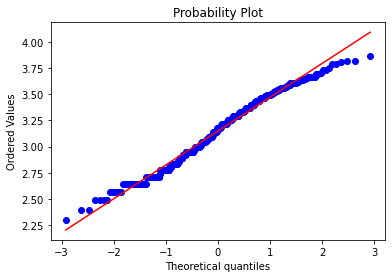

In [29]:
fig=plt.figure()
stats.probplot(data['mpg'],plot=plt)
plt.show()

In [30]:
#feature- independent variable
skewed_feats = data.drop('origin', axis=1).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness=pd.DataFrame(skewed_feats, columns=['skewned'])

In [31]:
skewness

,skewned
horsepower,1.102051
displacement,0.716930
weight,0.529059
cylinders,0.524934
acceleration,0.277725
model year,0.011491
mpg,-0.108727


## One Hot encoding

In [32]:
data['cylinders'] = data['cylinders'].astype(str)

In [33]:
data = pd.get_dummies(data,drop_first=True)

In [34]:
data.head()

,mpg,displacement,horsepower,weight,acceleration,model year,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_Japan,origin_USA
0,2.944439,307.0,130.0,3504,12.0,70,0,0,0,1,0,1
1,2.772589,350.0,165.0,3693,11.5,70,0,0,0,1,0,1
2,2.944439,318.0,150.0,3436,11.0,70,0,0,0,1,0,1
3,2.833213,304.0,150.0,3433,12.0,70,0,0,0,1,0,1
4,2.890372,302.0,140.0,3449,10.5,70,0,0,0,1,0,1


In [35]:
#Split and StandardScale
X_train = data.drop(['mpg'],axis=1)
y_train = data['mpg']
scale = StandardScaler()

In [36]:
X_train=scale.fit_transform(X_train)

## Modeling

In [37]:
def train_show_reshults(X ,y , model,split_share=0.3):
    print(f"Training using {model}")
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = split_share)
    M = model.fit(X_train,y_train)
    y_pred = M.predict(X_test)
    mse = MSE(y_test,y_pred)
    rmse = math.sqrt(mse)
    print(f"MSE: {mse}")
    print("---------------------------")
    print(f"RMSE: {rmse}")
    print("###########################\n")

In [38]:
models=[LinearRegression(), Ridge(), Lasso(), ElasticNet(),
       XGBRegressor(objective='reg:linear', max_depth=5, min_child_weight=4, subsample=0.7, n_estimators=100, learning_rate=0.7)]
for model in models:
    train_show_reshults(X_train,y_train,model)

Training using LinearRegression()
MSE: 0.013301111184142272
---------------------------
RMSE: 0.11533044344032616
###########################

Training using Ridge()
MSE: 0.011385024213230278
---------------------------
RMSE: 0.10670062892612338
###########################

Training using Lasso()
MSE: 0.10639702539201029
---------------------------
RMSE: 0.3261855689511881
###########################

Training using ElasticNet()
MSE: 0.11761969724683098
---------------------------
RMSE: 0.3429572819562678
###########################

Training using XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.7, max_delta_step=None, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             object

## Model Tuning

In [46]:
def modeling(X,y,model,tuned_params,split_share=0.3,n_folds=5,slogx=True):
    print(f"Training using {model} with {tuned_params}")
    X_train, X_test, y_train,y_test= train_test_split(X,y,test_size=split_share,)
    clf = GridSearchCV(model,tuned_params,cv=n_folds,
                      scoring="neg_mean_squared_error",n_jobs=5)
    clf.fit(X_train,y_train)
    scores = clf.cv_results_['mean_test_score']
    best_model = clf.best_estimator_
    best_model.fit(X_train,y_train)
    y_pred = best_model.predict(X_test)
    mse = MSE(y_test,y_pred)
    print(f"MSE: {mse}")
    
    if slogx:
        plt.semilogx(tuned_params['alpha'],scores)
    

Training using Ridge(max_iter=10000, random_state=42) with {'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01])}
MSE: 0.010574268557034045


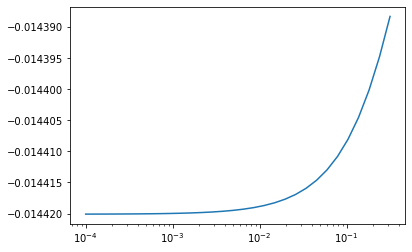

In [47]:
alphas = np.logspace(-4,-0.5,30)
tuned_params = {'alpha':alphas}
modeling(X_train,y_train,Ridge(random_state=42,max_iter=10000),tuned_params)
